In [1]:
cd "/data/ai_club/team_C/"

/data/ai_club/team_C


In [2]:
from sklearn import svm
import numpy as np
from sklearn.model_selection import train_test_split
import joblib
from spectral import *
from PIL import Image, ImageFile
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Conv2D 
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', 

In [3]:
#Model Setup
#Data Files
data_train = np.load('CNN/spectral_lymph_tile_array_3_9_22_left_update_1.npy')
non_data_train = np.load('CNN/spectral_non_tile_array_3_9_22_left_update_1.npy')
data_test = np.load('CNN/spectral_lymph_tile_array_3_9_22_right_update_1.npy')
non_data_test = np.load('CNN/spectral_non_tile_array_3_9_22_right_update_1.npy')

data_stack_train = np.vstack((data_train, non_data_train)) # One array of all training data
data_stack_test = np.vstack((data_test, non_data_test))   # One array of all test data
labels_train = np.append(np.ones(data_train.shape[0]), np.zeros(non_data_train.shape[0])) 
labels_test = np.append(np.ones(data_test.shape[0]), np.zeros(non_data_test.shape[0]))

X_train = data_stack_train[:, :]
y_train = labels_train[:]
X_test =  data_stack_test[:, :]
y_test = labels_test[:]
print("Data Loaded")
#Model
model=Sequential()
model.add(Conv2D(filters=128,kernel_size=3,padding="same",activation="relu",input_shape=(17,17,394)))
model.add(Conv2D(filters=16,kernel_size=3,padding="same",activation="relu"))
model.add(Flatten())
model.add(Dense(500,activation="relu"))
model.add(Dense(1,activation="sigmoid"))  
print(model.summary())
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) #compile Model
history=model.fit(X_train,y_train,epochs=3, validation_data=(X_test,y_test)) #train model

W0322 20:02:28.191759 139915298666304 deprecation.py:506] From /usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0322 20:02:28.285766 139915298666304 deprecation.py:323] From /usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Data Loaded
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 17, 17, 128)       454016    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 17, 17, 16)        18448     
_________________________________________________________________
flatten (Flatten)            (None, 4624)              0         
_________________________________________________________________
dense (Dense)                (None, 500)               2312500   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 501       
Total params: 2,785,465
Trainable params: 2,785,465
Non-trainable params: 0
_________________________________________________________________
None
Train on 19011 samples, validate on 22601 samples
Epoch 1/3
19011/19011 [======================

(17912, 20292, 394)
(17912, 20292)


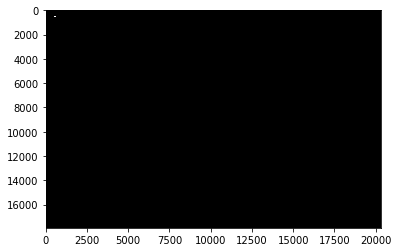

In [4]:
#Loading Spectral Array and creating cropped spectral array 
Image.MAX_IMAGE_PIXELS = None
ImageFile.LOAD_TRUNCATED_IMAGES = True
spectral_img = open_image('ov-63-hd-16ca.hdr')
print(spectral_img.shape)
size=100 #Squaresize
crop_x=500
crop_y=500
spectral_shape=spectral_img.shape
spectral_2d_shape=spectral_shape[:2]
print(spectral_2d_shape)
mask = np.zeros((spectral_2d_shape))
mask[crop_x:(crop_x+size),crop_x:(crop_x+size)]=1

fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(mask, aspect='auto', cmap=plt.cm.gray, interpolation='nearest')


In [6]:
#Create 17x17 tiles
# Tile radius (1 = 3x3, 2 = 5x5, 3 = 7x7, etc.)
tr = 8


# Finding (y,x) tuple for where the mask is True
y, x = np.where(mask == True)

# Declaring pixel array
tw = 1 + (tr * 2)
test_spectral_result = np.empty((len(y), tw, tw, 394))

# # Append the pixels in the spectral image to the pixel array for every (y,x) and (ny,nx) tuple
print("Creating spectral array...")
for index, point in enumerate(zip(y, x)):
    px, py = point[1], point[0]
    #print((index/float(len(y)))*100) # If you want to see progress for large tables
    test_spectral_result[index] = spectral_img[py-tr:py+tr+1, px-tr:px+tr+1]
print("Done")

Creating spectral array...
0.0
0.01
0.02
0.03
0.04
0.05
0.06
0.06999999999999999
0.08
0.09
0.1
0.11
0.12
0.13
0.13999999999999999
0.15
0.16
0.16999999999999998
0.18
0.19
0.2
0.21
0.22
0.22999999999999998
0.24
0.25
0.26
0.27
0.27999999999999997
0.29
0.3
0.31
0.32
0.33
0.33999999999999997
0.35000000000000003
0.36
0.37
0.38
0.38999999999999996
0.4
0.41000000000000003
0.42
0.43
0.44
0.44999999999999996
0.45999999999999996
0.47000000000000003
0.48
0.49
0.5
0.51
0.52
0.53
0.54
0.5499999999999999
0.5599999999999999
0.5700000000000001
0.58
0.59
0.6
0.61
0.62
0.63
0.64
0.65
0.66
0.67
0.6799999999999999
0.69
0.7000000000000001
0.7100000000000001
0.72
0.73
0.74
0.75
0.76
0.77
0.7799999999999999
0.79
0.8
0.8099999999999999
0.8200000000000001
0.83
0.84
0.8500000000000001
0.86
0.8699999999999999
0.88
0.89
0.8999999999999999
0.91
0.9199999999999999
0.9299999999999999
0.9400000000000001
0.95
0.96
0.97
0.98
0.9900000000000001
1.0
1.01
1.02
1.03
1.04
1.05
1.06
1.0699999999999998
1.08
1.09
1.099999999999

In [7]:
predictions=model.predict(test_spectral_result)

(10000, 1)


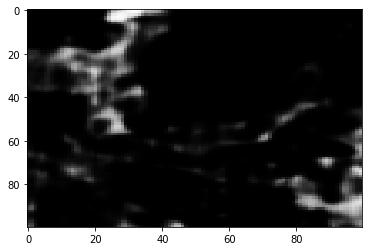

In [8]:
print(predictions.shape)
predictions=predictions.reshape(size,size)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(predictions, aspect='auto', cmap=plt.cm.gray, interpolation='nearest')
im = Image.fromarray(predictions)
im_rgb = im.convert('RGB')
im_rgb.save("predictions.png")

In [ ]:
#Todo: Write code to make a mask file out of this file for easy comparison to hyperspectral file